# Counting fraction of filled bins across contact distances

In [2]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import numpy as np
import pandas as pd

# import open2c libraries
import bioframe
import cooler
import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.0'):
    raise AssertionError("tutorials rely on cooltools version 0.5.0 or higher,"+
                         "please check your cooltools version and update to the latest")

    
resolution = 100 # input the desired data resolution for analysis
distances = [1000,2500,5000,10000,25000,50000,100000,250000,500000,1000000] # input the desired contact distance diagonals in bp

# Load in each of the datasets at the specified resolution
clr_RCMC = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clr_TMCC = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clr_Hsieh = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clr_Bonev = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))

# List the Capture regions for RCMC & TMCC
## To ensure an apples-to-apples comparison, the genome-wide Micro-C (Hsieh 2020) and Hi-C (Bonev 2017) datasets will be analyzed for the same regions as RCMC instead of across the entire genome
regionsRCMC = ['chr3:33804149-35704149','chr5:31257344-32382344','chr6:122451959-122876959','chr8:84846629-85856629','chr18:58032072-59034072']
regionsTMCC = ['chr3:34365200-35640000','chr6:122606805-122856450']


# Variables for storing fill fraction data
countsAcrossDistances = [] # Stores the fraction of all non-empty bins for each dataset (across all regions) for each of the specified contact distances
nonZeroFracsByRegionAcrossDistances = [] # Stores the fraction of all non-empty bins for each dataset (region-separated) for each of the specified contact distances

for distance in distances:
    compiledCounts = [] # Stores the total number of bins and number of non-empty bins for each region of each dataset at the given contact distance

    coolers = [clr_RCMC,clr_TMCC,clr_Hsieh,clr_Bonev]
    coolerIt = 0 # An iterating variable for going through each of the datasets
    while coolerIt < len(coolers):
        if coolerIt == 1:
            regions = regionsTMCC # Use the TMCC regions for calculation for the TMCC dataset
        else:
            regions = regionsRCMC # Use the RCMC regions for calculation for the RCMC, Hsieh, & Bonev datasets

        totBins = [] # Counts the number of total contact bins for at the given contact distance
        nonZeroBins = [] # Counts the number of contact bins that have at least one read in them at the given contact distance

        for i in regions:        
            # Iterating region by region for the given dataset, load in the contact matrix
            # Keep balancing off to count raw read counts
            regionMat = coolers[coolerIt].matrix(balance=False).fetch(i)
            
            bins = len(regionMat) # Get the number of genomic bins across the matrix
            offset = distance // resolution - 1 # Calculate the number of fewer genomic bins at the given contact distance
            binsAtDiag = bins - offset # Calculate the total number of contact bins at the contact distance
            totBins.append(binsAtDiag)

            # Set the stage for iterating across the contact diagonal at the given distance to count the number of empty bins
            x = offset
            y = 0
            nonZeroCount = 0
            
            # Iterate through the contact diagonal tallying non-empty bins until the end of the diagonal
            while x < len(regionMat):
                val = regionMat[y][x]
                if val > 0:
                    nonZeroCount += 1
                x += 1
                y += 1
            nonZeroBins.append(nonZeroCount)

        binCounts = [totBins,nonZeroBins] # Combine the total bin & non-empty bin counts into a tuple
        compiledCounts.append(binCounts) # Add the combined tuple for the given dataset & region to compiledCounts

        coolerIt += 1 # Onwards to the next cooler in the dataset list

    # print(compiledCounts) # Sanity check that the code is working 

    totNonZeroFrac = [] # Stores the across-regions fraction of non-empty bins for each dataset at a given contact distance
    nonZeroFracsByRegion = [] # The region-separated version of totNonZeroFrac

    # Iterate through compiledCounts to extract filled bin fractions
    for i in compiledCounts:
        sumPossible = sum(i[0]) # Sums the total number of bins across all regions for a dataset
        sumNonZero = sum(i[1]) # Sums the total number of non-empty bins across all regions for a dataset
        totNonZeroFrac.append(sumNonZero / sumPossible) # Adds the non-empty bin fraction to totNonZeroFrac

        regionFracs = [] # An array to hold the non-empty bin fraction by region for a given dataset
        for j in range(len(i[0])): # Iterate across the regions
            fracNonZero = i[1][j] / i[0][j] # Calculate non-empty bin fraction for the given region
            regionFracs.append(fracNonZero) # Add the calculated fraction to regionFracs
        nonZeroFracsByRegion.append(regionFracs) # Add the array of non-empty bin fractions by region to nonZeroFracsByRegion

    # print(totNonZeroFrac) # Double-check that totNonZeroFrac is calculating as expected
    # print(nonZeroFracsByRegion) # Double-check that nonZeroFracsByRegion is calculating as expected
    
    countsAcrossDistances.append(totNonZeroFrac) # Add totNonZeroFrac, which contains the non-zero bin fraction for each dataset at the given contact distance, to countsAcrossDistances
    nonZeroFracsByRegionAcrossDistances.append(nonZeroFracsByRegion) # Add nonZeroFracsByRegion, which contains the region-separated non-zero bin fraction for each dataset at the given contact distance, to nonZeroFracsByRegionAcrossDistances
    
countsAcrossDistances # Print the output of countsAcrossDistances to confirm that it produces a logical result

In [3]:
# Separate the nested array of countsAcrossDistance by dataset for ease of calculation & plotting
RCMCcounts = []
TMCCcounts = []
Hsiehcounts = []
Bonevcounts = []

for i in countsAcrossDistances:
    RCMCcounts.append(i[0])
    TMCCcounts.append(i[1])
    Hsiehcounts.append(i[2])
    Bonevcounts.append(i[3])

In [6]:
# Separate out the nested array of nonZeroFracsByRegionAcrossDistances to extract the RCMC & TMCC region counts for ease of calculation & plotting
RCMCRegionCounts = []
TMCCRegionCounts = []

for distanceSet in nonZeroFracsByRegionAcrossDistances:
    RCMCRegionCounts.append(distanceSet[0])
    TMCCRegionCounts.append(distanceSet[1])

In [7]:
# Separate out the nested array of region counts by individual region for RCMC & TMCC for ease of plotting
RCMC_Sox2 = []
RCMC_Ppm1g = []
RCMC_Nanog = []
RCMC_Klf1 = []
RCMC_Fbn2 = []
TMCC_Sox2 = []
TMCC_Nanog = []

for i in RCMCRegionCounts:
    RCMC_Sox2.append(i[0])
    RCMC_Ppm1g.append(i[1])
    RCMC_Nanog.append(i[2])
    RCMC_Klf1.append(i[3])
    RCMC_Fbn2.append(i[4])
    
for j in TMCCRegionCounts:
    TMCC_Sox2.append(j[0])
    TMCC_Nanog.append(j[1])

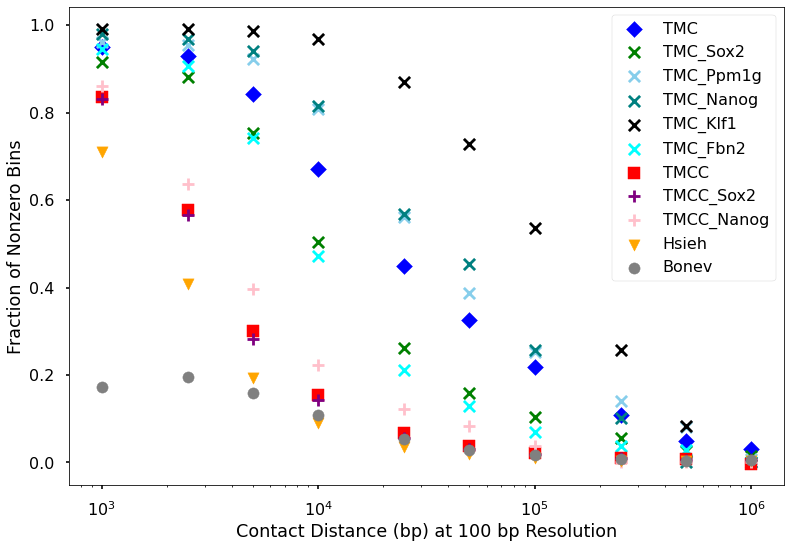

In [21]:
# Plot the fraction of filled bins across contact distances both by region and averaged across regions

import matplotlib.pyplot as plt

saveDir = f'DIRECTORY_PATH'
fileName = f'FILE_NAME.svg' # swap out .svg for the desired output file format

plt.scatter(distances, RCMCcounts, marker = 'D', c = 'blue', label='RCMC')
plt.scatter(distances, RCMC_Sox2, marker = 'x', c = 'green', label='RCMC_Sox2')
plt.scatter(distances, RCMC_Ppm1g, marker = 'x', c = 'skyblue', label='RCMC_Ppm1g')
plt.scatter(distances, RCMC_Nanog, marker = 'x', c = 'teal', label='RCMC_Nanog')
plt.scatter(distances, RCMC_Klf1, marker = 'x', c = 'black', label='RCMC_Klf1')
plt.scatter(distances, RCMC_Fbn2, marker = 'x', c = 'cyan', label='RCMC_Fbn2')
plt.scatter(distances, TMCCcounts, marker = 's', c = 'red', label='TMCC')
plt.scatter(distances, TMCC_Sox2, marker = '+', c = 'purple', label='TMCC_Sox2')
plt.scatter(distances, TMCC_Nanog, marker = '+', c = 'pink', label='TMCC_Nanog')
plt.scatter(distances, Hsiehcounts, marker = 'v', c = 'orange', label='Hsieh')
plt.scatter(distances, Bonevcounts, marker = 'o', c = 'gray', label='Bonev')
plt.xscale("log")
plt.xlabel("Contact Distance (bp) at 100 bp Resolution")
plt.ylabel("Fraction of Nonzero Bins")
plt.legend()

# plt.savefig(saveDir + fileName, dpi=1200)
plt.show()